In [1]:
# 青光眼检测baseline

# 导入库
import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, resnet101

import torchvision.transforms as trans

import warnings
warnings.filterwarnings('ignore')

Total Nums: 100, train: 80, val: 20


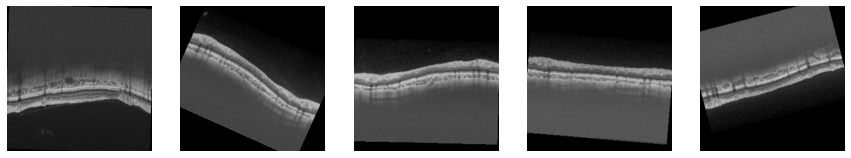

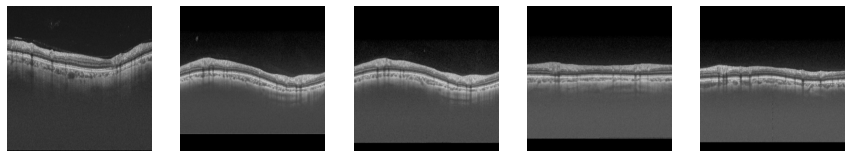

In [44]:
# 配置
batchsize = 8 # 批大小,
image_size = 256
iters = 1000 # 迭代次数
val_ratio = 0.2 # 训练/验证数据划分比例，80 / 20
trainset_root = "../datasets/Train/Image"
val_root = "../datasets/Train/Image"
test_root = "../datasets/Validation/Image"
num_workers = 4
init_lr = 1e-6
optimizer_type = 'adam'

# 训练/验证数据集划分
filelists = os.listdir(trainset_root)
train_filelists, val_filelists = train_test_split(filelists, test_size=val_ratio, random_state=42)
print("Total Nums: {}, train: {}, val: {}".format(len(filelists), len(train_filelists), len(val_filelists)))

# 数据加载（继承torch.utils.data中的Dataset类）
class GOALS_sub2_dataset(Dataset):
    def __init__(self,
                img_transforms,
                dataset_root,
                label_file='',
                filelists=None,
                numclasses=2,
                mode='train'):
                self.dataset_root = dataset_root
                self.img_transforms = img_transforms
                self.mode = mode.lower()
                self.num_classes = numclasses

                if self.mode == 'train':
                    label = {row['ImgName']:row[1]
                            for _, row in pd.read_excel(label_file).iterrows()}
                    self.file_list = [[f, label[int(f.split('.')[0])]] for f in os.listdir(dataset_root)]

                elif self.mode == "test":
                    self.file_list = [[f, None] for f in os.listdir(dataset_root)]
                
                if filelists is not None:
                    self.file_list = [item for item in self.file_list if item[0] in filelists]
    
    def __getitem__(self, idx):

        real_index, label = self.file_list[idx]
        img_path = os.path.join(self.dataset_root, real_index)    
        img = cv2.imread(img_path)
        
        if self.img_transforms is not None:
            img = self.img_transforms(img)
 
        # normlize on GPU to save CPU Memory and IO consuming.
        # img = (img / 255.).astype("float32")
        # print(img.shape)
        # img = img.transpose(2, 0).transpose(1,2) # H, W, C -> C, H, W

        if self.mode == 'test':
            return img, real_index

        if self.mode == "train":            
            return img, label

    def __len__(self):
        return len(self.file_list)

# 数据增强
img_train_transforms = trans.Compose([
    trans.ToTensor(),
    trans.RandomResizedCrop(
        image_size, scale=(0.90, 1.1), ratio=(0.90, 1.1)), # scale与原图像面积大小范围，ratio剪裁后宽高比
    trans.RandomHorizontalFlip(), # 随机水平翻转
    trans.RandomVerticalFlip(), # 随机垂直翻转
    trans.RandomRotation(30)
])

img_val_transforms = trans.Compose([
    trans.ToTensor(),
    # trans.CenterCrop(image_size),
    trans.Resize((image_size, image_size))
])

# 可视化并检查数据加载
_train = GOALS_sub2_dataset(dataset_root=trainset_root, 
                            img_transforms=img_train_transforms, 
                            label_file='../datasets/Train/Train_GC_GT.xlsx')


plt.figure(figsize=(15, 5))
for i in range(5):
    img, lab = _train.__getitem__(i)
    plt.subplot(1, 5, i+1)
    plt.imshow(img.transpose(2,0).transpose(0,1))
    plt.axis("off")

_val = GOALS_sub2_dataset(dataset_root=trainset_root, 
                        img_transforms=img_val_transforms,
                        label_file='../datasets/Train/Train_GC_GT.xlsx')

plt.figure(figsize=(15, 5))
for i in range(5):
    img, lab = _val.__getitem__(i)
    plt.subplot(1, 5, i+1)
    plt.imshow(img.transpose(2,0).transpose(0,1))
    plt.axis("off")


In [45]:
# 网络模型
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.feature = resnet50(pretrained=True, num_classes=2) # 移除最后一层全连接
        # self.feature = resnet101(pretrained=True, num_classes=2) # 移除最后一层全连接
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, img):
        feature = self. feature(img)
        out1 = self.fc1(feature)
        logit = self.fc2(out1)

        return logit


In [ ]:

# 功能函数
def train(model, iters, train_dataloader, val_dataloader, optimizer, criterion, log_interval, eval_interval):
    iter = 0
    model.train()
    avg_loss_list = []
    avg_acc_list = []
    best_acc = 0.
    n_correct = 0
    n_total = 0
    while iter < iters:
        for data in train_dataloader: # 便利dataloader得到的data为一个batch里的图像和label
            iter += 1
            if iter > iters:
                break
            imgs = (data[0] / 255.).astype("float32")
            labels = data[1].astype('int64')
            # print(labels)
            # labels_ = torch.unsqueeze(labels, axis=1) # 维度扩展：一维80-->二维80*1
            logits = model(imgs) 
            # m = paddle.nn.Softmax()
            # pred = m(logits)
            # print(pred.numpy())
            # print(pred.numpy().argmax(1))            
            # acc = paddle.metric.accuracy(input=pred, label=labels_)
            _, indices = logits.max(dim=1) # 找出行最大值，返回索引
            n_correct += sum(indices==labels)
            n_total += len(labels)
            acc = n_correct.cpu().detach().numpy() * 1.0 /n_total
            # one_hot_labels = paddle.fluid.layers.one_hot(labels_, 2, allow_out_of_range=False)
            loss = criterion(logits, labels)            
            # print(loss.numpy())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


            # model.clear_gradients()
            avg_loss_list.append(loss.numpy()[0])
            avg_acc_list.append(acc.numpy())
            

            if iter % log_interval == 0:
                avg_loss = np.array(avg_loss_list).mean()
                avg_acc = np.array(avg_acc_list).mean()
                avg_loss_list = []
                avg_acc_list = []
                print("[TRAIN] iter={}/{} avg_loss={:.4f} avg_acc={:.4f}".format(iter, iters, avg_loss, avg_acc))

            if iter % eval_interval == 0:
                avg_loss, avg_acc = val(model, val_dataloader, criterion)
                print("[EVAL] iter={}/{} avg_loss={:.4f} acc={:.4f}".format(iter, iters, avg_loss, avg_acc))
                if avg_acc >= best_acc:
                    best_acc = avg_acc
                    paddle.save(model.state_dict(),
                            os.path.join("/xx/task1_models/best_model_{:.4f}".format(best_acc), 'model.pdparams'))
                model.train()


